<a href="https://colab.research.google.com/github/GianRomani/Neural_search_engine/blob/main/Project-neural-ir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Not working on Colab, it should work in local. It is needed to use GPU with multiprocess (in Flow)
%env JINA_MP_START_METHOD='spawn'
import os
import torch.multiprocessing as mp

print(os.getenv("JINA_MP_START_METHOD"))
mp.set_start_method('spawn', force=True)

env: JINA_MP_START_METHOD='spawn'
'spawn'


In [2]:
try: 
  #this will raise an error if you are not using Colab
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print("You are not using Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

In [4]:
questions = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Questions_small.csv", encoding="ISO-8859-1")
answers = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Answers.csv", encoding="ISO-8859-1")

index_outfile = "/content/drive/MyDrive/Data Mining/Project/index_1k.csv"

# EDA

It can be interesting and helpful to analyze:

*   the distribution of the scores among the questions,
*   number of answers for question (and scores of those answers);
*   creation dates for the posts;
*   if a post was closed (and why);
*   popular users (who answered a lot of questions)





<h2>Questions</h2>

*   Id: id of the question;
*   OwnerUserId: id of the account who post the question;
*   CreationDate: when the question was posted;
*   ClosedDate: when the question was closed;
*   Score: upvotes - downvotes;
*   Title: title of the question;
*   Body: the question

In [5]:
questions.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


In [6]:
questions.describe()

,Id,OwnerUserId,Score
count,10000.000000,8.942000e+03,10000.00000
mean,345670.304000,5.991235e+04,18.72520
std,180790.563023,2.505130e+05,96.13298
min,80.000000,1.000000e+00,-5.00000
25%,198300.000000,5.325750e+03,1.00000
50%,353070.000000,1.933900e+04,3.00000
75%,505542.500000,3.967700e+04,10.00000
max,637920.000000,3.742716e+06,5190.00000


In [7]:
#What is the distribution of the scores among the questions?
score_distribution = questions["Score"].value_counts(bins=20)
score_distribution

(-10.196, 254.75]    9881
(254.75, 514.5]        82
(514.5, 774.25]        17
(774.25, 1034.0]       10
(1034.0, 1293.75]       3
(2332.75, 2592.5]       2
(1293.75, 1553.5]       2
(3371.75, 3631.5]       1
(4930.25, 5190.0]       1
(1553.5, 1813.25]       1
(2073.0, 2332.75]       0
(1813.25, 2073.0]       0
(2852.25, 3112.0]       0
(3112.0, 3371.75]       0
(3631.5, 3891.25]       0
(3891.25, 4151.0]       0
(4151.0, 4410.75]       0
(4410.75, 4670.5]       0
(4670.5, 4930.25]       0
(2592.5, 2852.25]       0
Name: Score, dtype: int64

In [8]:
#negative scores
negative_scores_questions = questions[questions["Score"] < 0]
negative_scores_questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
487,43960,3262.0,2008-09-04T15:07:30Z,NaN,-1,COTS Workshop Registration System,<p>Does anyone have any experience with any CO...
890,73260,12550.0,2008-09-16T14:57:37Z,NaN,-1,What is your choice for a Time Managment Solut...,<p>I've come across a few different applicatio...
904,74570,7709.0,2008-09-16T17:02:14Z,NaN,-1,CSS : Bad Gray Line to the side of the Navigat...,"<p>I'm maintaining <a href=""http://perl-begin...."
949,79350,NaN,2008-09-17T02:37:37Z,2015-06-23T23:33:20Z,-1,What open source virtual private server progra...,<p>I am looking to have 4 Virtual servers(vari...
1017,85370,6992.0,2008-09-17T17:01:08Z,NaN,-2,"Most common cause of ""java.lang.NullPointerExc...",<p>My strongest lead is that the code who deal...
...,...,...,...,...,...,...,...
9780,627350,53491.0,2009-03-09T17:57:35Z,NaN,-2,Will creating a new folder break subversion?,"<p>I have a subversion repository, but there a..."
9852,631320,NaN,2009-03-10T17:07:04Z,NaN,-1,Does anyone know of any good (and cheap) domai...,<p>I use 1and1 mainly - through legacy/lethar...
9868,632090,76343.0,2009-03-10T20:17:19Z,NaN,-2,Where is the documentation for CGI.pm?,<p>A google search reveals nothing useful. Do...
9912,634260,44984.0,2009-03-11T12:12:43Z,NaN,-1,How can I sum values in a MySQL query?,<p>I am using MySQL.<br />\nI have a P_id that...


In [9]:
#Posts with a score greater than 4000
best_posts = questions[questions["Score"] >4000]
best_posts

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
4907,348170,14069.0,2008-12-07T21:57:46Z,NaN,5190,How to undo 'git add' before commit?,<p>I mistakenly added files using the command:...


In [10]:
#Count NaN values -> most of them in ClosedDate
questions.isna().sum()

Id                 0
OwnerUserId     1058
CreationDate       0
ClosedDate      9357
Score              0
Title              0
Body               0
dtype: int64

<h2>Answers</h2>


*   Id: id of the answer;
*   OwnerUserId: id of the account who post the answer;
*   CreationDate: when the answer was posted;
*   ParentId: Id of the question;
*   Score: upvotes - downvotes;
*   Body: the answer



In [11]:
answers.head(10)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi..."
8,473,49.0,2008-08-02T15:33:13Z,470,8,"<p>No, what you're doing is fine. Don't let th..."
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...


In [12]:
answers.describe()

,Id,OwnerUserId,ParentId,Score
count,2.014516e+06,2.001316e+06,2.014516e+06,2.014516e+06
mean,1.915490e+07,1.487613e+06,1.808390e+07,2.480563e+00
std,1.168713e+07,1.549051e+06,1.169152e+07,1.590938e+01
min,9.200000e+01,1.000000e+00,8.000000e+01,-4.200000e+01
25%,8.854490e+06,2.818680e+05,7.692900e+06,0.000000e+00
50%,1.866246e+07,9.546430e+05,1.712404e+07,1.000000e+00
75%,2.929756e+07,2.197072e+06,2.804977e+07,2.000000e+00
max,4.014339e+07,7.045028e+06,4.014319e+07,5.718000e+03


In [13]:
#Distribution for the scores of the answers
score_distribution = answers["Score"].value_counts(bins=20)
score_distribution

(-47.760999999999996, 246.0]    2013578
(246.0, 534.0]                      708
(534.0, 822.0]                      150
(822.0, 1110.0]                      34
(1398.0, 1686.0]                     17
(1110.0, 1398.0]                      8
(1686.0, 1974.0]                      6
(2262.0, 2550.0]                      4
(2838.0, 3126.0]                      4
(1974.0, 2262.0]                      3
(3414.0, 3702.0]                      2
(2550.0, 2838.0]                      1
(5430.0, 5718.0]                      1
(3126.0, 3414.0]                      0
(3702.0, 3990.0]                      0
(3990.0, 4278.0]                      0
(4278.0, 4566.0]                      0
(4566.0, 4854.0]                      0
(4854.0, 5142.0]                      0
(5142.0, 5430.0]                      0
Name: Score, dtype: int64

In [14]:
#negative scores
negative_scores_answers = answers[answers["Score"] < 0]
negative_scores_answers

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
259,7896,268.0,2008-08-11T16:07:31Z,7880,-2,<p>fstream are great but I will go a little de...
284,8421,785.0,2008-08-12T02:37:15Z,6430,-2,"<p>Aha, I was really just testing everyone onc..."
386,10687,234.0,2008-08-14T05:03:34Z,10610,-1,<p>e-texteditor hilights what you're searching...
483,12098,198.0,2008-08-15T09:24:51Z,10980,-2,<p>I'm not a lawyer but all licenses mentioned...
498,12885,872.0,2008-08-15T23:27:13Z,12870,-1,<p>There is no pretty solution. Java just doe...
...,...,...,...,...,...,...
2014340,40139542,541038.0,2016-10-19T19:02:35Z,40139460,-1,<pre><code>CHUNKSIZE=1024 # read 1024 bytes at...
2014343,40139568,3220135.0,2016-10-19T19:04:27Z,40139460,-1,<p>depending on how your particular data is br...
2014347,40139589,5912548.0,2016-10-19T19:06:08Z,40137060,-1,"<p>I don't have ggplot installed, but maybe a ..."
2014360,40139866,3831435.0,2016-10-19T19:21:27Z,40139500,-1,"<p>Try this:</p>\n\n<pre><code>#include ""stdaf..."


In [15]:
#Number of answers for question
answers_for_post = answers.groupby(["ParentId"]).count()["Id"]
answers_for_post

ParentId
80          3
90          3
120         1
180         9
260         9
           ..
40142860    1
40142900    1
40142910    1
40142940    2
40143190    2
Name: Id, Length: 1102568, dtype: int64

In [16]:
#max number of answers for a post
answers_for_post.max()

408

In [17]:
#How many questions have a certain number of answers?
print("#answers   #questions")
answers_for_post.value_counts()

#answers   #questions


1      606272
2      284868
3      117396
4       49255
5       21767
6       10005
7        5132
8        2760
9        1553
10        954
11        702
12        508
13        311
14        237
15        187
16        125
17        100
18         86
19         54
20         42
21         31
22         31
23         29
24         22
25         17
27         16
26         15
29         12
31         11
28         11
30         11
32          7
34          5
33          5
38          3
40          3
36          3
35          2
39          2
43          2
49          1
67          1
42          1
50          1
41          1
59          1
408         1
45          1
100         1
55          1
51          1
61          1
69          1
316         1
129         1
37          1
Name: Id, dtype: int64

In [18]:
#How many NaN values?
answers.isna().sum()

Id                  0
OwnerUserId     13200
CreationDate        0
ParentId            0
Score               0
Body                0
dtype: int64

In [19]:
#How many questions were answered by the users?
users_and_number_of_answers = answers["OwnerUserId"].value_counts()
print("UserId     #answers")
users_and_number_of_answers

UserId     #answers


22656.0      3270
1144035.0    3009
29407.0      2144
548225.0     1924
115145.0     1813
             ... 
3072736.0       1
155506.0        1
2869216.0       1
2713587.0       1
4464432.0       1
Name: OwnerUserId, Length: 468797, dtype: int64

In [20]:
#Distribution of the number of answers posted by different users
print("#answers    #users")
users_and_number_of_answers.value_counts()

#answers    #users


1       262716
2        72701
3        35270
4        21035
5        13960
         ...  
411          1
413          1
415          1
419          1
3270         1
Name: OwnerUserId, Length: 484, dtype: int64

<h2>Tags</h2>


*   Id: id of the question
*   Tag: just the tag :)



In [21]:
tags = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Tags.csv", encoding="ISO-8859-1")

In [22]:
tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


In [23]:
#How many rows?
tags.shape[0]

3750994

In [24]:
#Check if there are some null values
tags.isna().sum()

Id        0
Tag    1113
dtype: int64

In [25]:
#Number of tags for post
number_of_tags_for_post = tags["Id"].value_counts()
print("Post     #tags")
number_of_tags_for_post

Post     #tags


11053790    5
5221980     5
25573000    5
25573010    5
16468060    5
           ..
8240020     1
11770790    1
21883080    1
3949000     1
34943370    1
Name: Id, Length: 1264216, dtype: int64

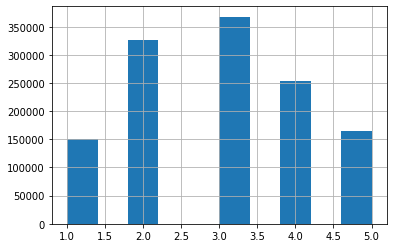

In [26]:
#Distribution of number of tags
number_of_tags_for_post.hist()

In [27]:
#Number of tags for post
tags_used = tags["Tag"].value_counts()
tags_used

javascript           124155
java                 115212
c#                   101186
php                   98808
android               90659
                      ...  
testcasesource            1
google-floodlight         1
iecapt                    1
netfs                     1
docker-windows            1
Name: Tag, Length: 37034, dtype: int64

In [28]:
counter = 0
for i in tags_used:
  if i > 10:
    counter+=1
counter

14177

In [29]:
#How many tags appear a certain number of times
print("#occurrences #tags")
occ_tags = tags_used.value_counts()
occ_tags

#occurrences #tags


1       6427
2       4148
3       2989
4       2245
5       1697
        ... 
1143       1
1139       1
1137       1
1136       1
671        1
Name: Tag, Length: 1193, dtype: int64

In [30]:
#distribution of how many tags appear a certain number of times
tags_used_groups = tags_used.value_counts(bins=20)
tags_used_groups

(-123.155, 6208.7]      36973
(6208.7, 12416.4]          29
(12416.4, 18624.1]         11
(18624.1, 24831.8]          5
(24831.8, 31039.5]          3
(37247.2, 43454.9]          2
(43454.9, 49662.6]          2
(74493.4, 80701.1]          1
(111739.6, 117947.3]        1
(99324.2, 105531.9]         1
(93116.5, 99324.2]          1
(86908.8, 93116.5]          1
(62078.0, 68285.7]          1
(55870.3, 62078.0]          1
(31039.5, 37247.2]          1
(117947.3, 124155.0]        1
(80701.1, 86908.8]          0
(68285.7, 74493.4]          0
(49662.6, 55870.3]          0
(105531.9, 111739.6]        0
Name: Tag, dtype: int64

# Preprocessing

In [31]:
import re
from bs4 import BeautifulSoup as soup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
def cleanpunc(sentence): 
    no_punct = sentence.translate(str.maketrans('', '', string.punctuation))
    return  no_punct

In [33]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    return phrase

In [34]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def clean_stop_words(total_text):
    if type(total_text) is not int:
        string = ""
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        return string  

list of stop words: {'our', 'its', "it's", "you've", 'his', "that'll", 'from', 'up', 'once', 'now', "isn't", "shan't", 'there', 'was', 'yours', 'he', 'yourselves', 'didn', 'in', 'into', 'd', "aren't", 'an', 'other', 'weren', 'll', 'having', 'himself', 'she', 'while', 'ain', "she's", 'over', 'o', 'these', 'what', 'of', 'not', "should've", 'some', 'are', 'such', 'between', 'by', 'your', 'itself', 'out', 'ma', 'only', "didn't", "doesn't", "hadn't", 'couldn', 'had', 'should', 'at', 'where', 'then', 'isn', 'y', 'is', 'whom', 'to', 'further', 'their', 'can', 'wouldn', 'won', 'as', 'because', 'my', 'under', "you'll", 'same', "won't", "needn't", 'mustn', 'ours', 're', 'no', 've', 'than', "wouldn't", 'or', 'above', 'you', 'through', 'for', "hasn't", 'did', "you'd", 'again', 'those', 'do', 'being', 'have', 'nor', "weren't", 'very', 'after', 'any', 'own', 'with', "haven't", 'off', 'm', 'myself', 'it', 'the', 'ourselves', 'they', 'if', 'against', 'on', 'will', 'i', 'who', 'shan', "wasn't", 'more',

In [35]:
def preprocessing_operations(text):
  splitted_text_code = re.split('<pre><code>|</code></pre>', text)
  res = []
  for idx, text in enumerate(splitted_text_code):
    if idx%2 == 0:
      no_html = soup(text, "lxml").text
      no_punctuation = cleanpunc(no_html)
      no_contractions = decontracted(no_punctuation)
      no_stopwords = clean_stop_words(no_contractions)
      res.append(no_stopwords)
    else:
      res.append(text)
  return res

def preprocess_data(data):
  cleaned_text = []
  if type(data)==type("string"): #preprocess a single text
    cleaned_text = preprocessing_operations(data)
  else: #preprocess sevaral texts in input
    body = data["Body"]
    for q in body:
      cleaned_text.append(preprocessing_operations(q))
  return cleaned_text

# Jina

In [36]:
!pip install jina

In [37]:
! pip install "transformers" "pytorch-lightning" 

In [38]:
!apt install libomp-dev
!pip install faiss
!pip install --upgrade faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [39]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from __future__ import division
from math import ceil
import numpy as np
from jina import Flow, Executor, requests, Document, DocumentArray
import faiss
import time

import warnings
warnings.filterwarnings('ignore')

In [40]:
device = 0
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


The authors of CodeBert set the MAX_LENGTH for the sentences to 512(+2) so, if the input vector is too big, I can not compute the embeddings -> two possible solutions (https://github.com/microsoft/CodeBERT/issues/16):

*   use an RNN over k representations to obtain a final embedding;
*   take the average of the representations.

To use the cosine distance we need vectors that have same length ->there are two ways to obtain a representation of same length for the texts:

*   use the [CLS] token;
*   use the average of the vectors




In [41]:
class MyTransformer(Executor):
    """Transformer executor class """

    def __init__(
            self,
            pretrained_model_name_or_path: str = "microsoft/codebert-base",
            *args,
            device: str = 'cpu',
            **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.model.to(device)
        print("Device used: {}".format(self.model.device))

    def add_special_tokens(self, tokens_ids):
      # add CLS (token_id is 101) and SEP (token_id is 102)
      ids = [101] + tokens_ids + [102]
      # add padding (token_id is 0)
      padding_length = 512-len(ids)
      for i in range(padding_length):
        ids += [0]
      #print("\n padding_length: {} - len(tokens_ids): {}\nTokens_ids: {}".format(padding_length, len(ids), ids))
      return ids

    def compute_embedding(self, tokens_ids):
      self.model.eval()
      with torch.no_grad():
        if(len(tokens_ids) <= 510):
          tokens_ids = self.add_special_tokens(tokens_ids)
          context_embeddings = self.model(torch.tensor(tokens_ids)[None,:].to(device))[0]
        else:
          k = ceil(len(tokens_ids) / 510.0)
          chunks = np.array_split(tokens_ids, k)
          for i in range(len(chunks)):
            chunks[i] = self.add_special_tokens(chunks[i].tolist())
          chunks_tensor = torch.tensor(chunks[0])[None,:].to(device)
          context_embeddings_list = self.model(chunks_tensor)[0].to(device)
          for i in range(1, len(chunks)):
            chunks_tensor = torch.tensor(chunks[i])[None,:].to(device)
            context_embeddings_list = torch.cat((context_embeddings_list, self.model(chunks_tensor)[0]), 1)
          dim = context_embeddings_list.shape[-1]
          context_embeddings = context_embeddings_list.to(device)
        #compute the average of the vectors
        avg_embeddings = torch.sum(context_embeddings,1)[0]
      return avg_embeddings
      
    @requests
    def encode(self, docs: 'DocumentArray', *args, **kwargs):
        start = time.time()
        texts = docs.texts
        for idx, q in enumerate(texts): 
          cleaned_q = preprocess_data(q)
          tokens = []
          for l in cleaned_q:
            code_tokens = self.tokenizer.tokenize(l)
            tokens += code_tokens
            tokens += [self.tokenizer.sep_token]
          tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
          docs[idx].embedding = self.compute_embedding(tokens_ids)
        print("Time needed to encode {} documents: {}".format(len(docs), time.time()-start))

In [52]:
class MyIndexer(Executor): #Indexer with Faiss library

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.index_output = None
        self.index_file = None
        self.index_output = kwargs["index_output"]

    @requests(on='/index')
    def index(self, docs: DocumentArray, mode: str = None, **kwargs): 
      dim = docs.embeddings.shape[1]
      nlist = 50  # how many cells
      m = 8  # number of centroid IDs in final compressed vectors
      bits = 8 # number of bits in each centroid

      embeddings = docs.embeddings.cpu().detach().numpy()
      quantizer = faiss.IndexFlatL2(dim)
      self.my_index = faiss.IndexIVFPQ(quantizer, dim, nlist, m, bits) 

      start = time.time()
      self.my_index.train(embeddings)
      self.my_index.add(embeddings)
      print("Time needed to train and add {} texts to the index: {} s".format(self.my_index.ntotal, time.time()-start))

      if(mode == "w"):
        #write index on disk
        faiss.write_index(self.my_index, self.index_output)

    @requests(on='/search')
    def search(self, docs: DocumentArray, k:int = 4, **kwargs):
        s, d = self.my_index.search(docs.embeddings.to("cpu").numpy(), k)
        start = time.time()
        print("Time needed to search {} query: {} s".format(len(docs), time.time()-start))
        print("Indexes of the most similar documents: {}\nwith distance: {}".format(d,s))
        return d[0]
          
    def print_index(self):
      for d in self.index:
        print("Document id: {}\nembedding: {} of shape: {}".format(d.id, d.embedding, d.embedding.shape))

In [43]:
def getKey(item):
  return item[2]

def get_answers(docIds: list, questions, answers):
  for i, idx in enumerate(docIds):
    if idx == -1: #This result is not valid
      continue
    print("{}th result:".format(i+1))
    #document
    doc = questions.loc[idx]
    doc_id = doc.Id
    #question's title
    title = doc["Title"]
    #question's body
    body_q = doc["Body"]
    #answers
    answers_q = answers.loc[answers.ParentId == doc_id]
    answers.drop(answers[answers.Score <= 0].index, inplace=True)
    if (answers_q.empty):
      #skip this question on SO -> maybe add as feature the fact that other documents will be retrieved instead
      continue
    answers_texts = []
    for a in answers_q.itertuples():
      answers_texts.append((a.Id, a.Body, a.Score))
    answers_texts_sorted = sorted(answers_texts, key=getKey, reverse=True)
    print("Doc Id: {}\nTitle: {}\nText:\n{}".format(doc_id, title, body_q))
    for j, a in enumerate(answers_texts_sorted):
      print("----------------------------")
      print("{}th answer's Id: {}, with score: {} and text:\n{}".format(j+1, a[0], a[2], a[1]))
    print("########################################")

In [53]:
def test_with_gpu(num_docs: int = 100, query:str = None, **kwargs):
  start = time.time()
  #index
  i = MyIndexer(index_output = kwargs["index_output"], index_file = kwargs["index_file"]) #pass operation = 'w' to write and save a new index on disk
  if(num_docs == 0): #load the whole dataset
    docArray = DocumentArray([Document(id=questions.iloc[i].Id, text=questions.iloc[i].Body) for i in range(len(questions))])
    print("Time needed to read the whole dataset: {} s".format(time.time()-start))
  else:
    docArray = DocumentArray([Document(id=questions.iloc[i].Id, text=questions.iloc[i].Body) for i in range(num_docs)])
    print("Time needed to read {} texts: {} s".format(num_docs, time.time()-start))
    #embeddings
    e = MyTransformer(device=device)
    e.encode(docArray)
    #create new index
    i.index(docArray, mode="w") 
  #query
  if(query is None):
    q = DocumentArray([Document(text=questions.iloc[1].Body)])
    e.encode(q)
  else:
    q = DocumentArray([Document(text = query)])
    e.encode(q)
  #search
  docs = i.search(q, k=5)
  get_answers(docs, questions, answers)

In [49]:
flow = (
        Flow()
            .add(name='MyTransformer', uses=MyTransformer, uses_with={'device': "cuda:0"}, gpus='all')
            .add(name='MyIndexer', uses=MyIndexer)
    )

In [50]:
flow.plot()

           Flow@640[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIE15VHJhbnNmb3JtZXI7CgpkaXJlY3Rpb24gTFI7CgpNeVRyYW5zZm9ybWVyL3JlcC0wWyJNeVRyYW5zZm9ybWVyIl06Ojpwb2Q7CmVuZDsKc3ViZ3JhcGggTXlJbmRleGVyOwoKZGlyZWN0aW9uIExSOwoKTXlJbmRleGVyL3JlcC0wWyJNeUluZGV4ZXIiXTo6OnBvZDsKZW5kOwpnYXRld2F5c3RhcnRbZ2F0ZXdheV06OjpHQVRFV0FZIC0tPiBNeVRyYW5zZm9ybWVyOjo6REVQTE9ZTUVOVDsKTXlUcmFuc2Zvcm1lcjo6OkRFUExPWU1FTlQgLS0+IE15SW5kZXhlcjo6OkRFUExPWU1FTlQ7Ck15SW5kZXhlcjo6OkRFUExPWU1FTlQgLS0+IGdhdGV3YXllbmRbZ2F0ZXdheV06OjpHQVRFV0FZOwpjbGFzc0RlZiBJTlNQRUNUIHN0cm9rZTojRjI5QzlGCmNsY

In [54]:
query_encoder = MyTransformer(device=device)
num_docs = 1000 #number of documents to read, 0 to load the whole dataset

if(device.type!="cpu"): #if you are using GPU
  print("\nInsert your query ('n' to not pass a query): ")
  q = input()
  if(q=='n'): #use a question from the dataset as query
    test_with_gpu(num_docs, index_output = index_outfile, index_file = index_outfile)
  else:
    test_with_gpu(num_docs, q, index_output = index_outfile, index_file = index_outfile)
else: #if you are not using GPU
  with flow:
      docArray = DocumentArray([Document(id=questions.iloc[i].Id, text=questions.iloc[i].Body) for i in range(num_docs)])
      flow.index(docArray, index_output = index_outfile, index_file = index_outfile)
      while(True):
        print("\nInsert your query (q to quit): ")
        q = input()
        if (q == "q"):
          print("\n\nGoodbye!")
          break
        query_encoder.encode(DocumentArray([q]))
        d = flow.search(
            inputs=DocumentArray(q)
            )
        get_answers(d, questions, answers)

Device used: cuda:0

Insert your query ('n' to not pass a query): 
n
Time needed to read 1000 texts: 0.2642660140991211 s
Device used: cuda:0


Token indices sequence length is longer than the specified maximum sequence length for this model (2312 > 512). Running this sequence through the model will result in indexing errors


Time needed to encode 1000 documents: 37.172717571258545
Time needed to train and add 1000 texts to the index: 0.4373021125793457 s
Time needed to encode 1 documents: 0.012794733047485352
Time needed to search 1 query: 1.9550323486328125e-05 s
Indexes of the most similar documents: [[  1 450 254 432 902]]
with distance: [[2.0684514 3.174683  4.383759  5.279984  5.6435857]]
1th result:
Doc Id: 90
Title: Good branching and merging tutorials for TortoiseSVN?
Text:
<p>Are there any really good tutorials explaining <a href="http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html" rel="nofollow">branching and merging</a> with Apache Subversion? </p>

<p>All the better if it's specific to TortoiseSVN client.</p>

----------------------------
1th answer's Id: 1466832, with score: 19 and text:
<p>My easy click-by-click instructions (<strong>specific to TortoiseSVN</strong>) are in Stack&nbsp;Overflow question <em><a href="http://stackoverflow.com/questions/1461922">What is the simplest way to d